# Image synthesis with GAN

#Seminar part

We will try to generate **T2-weighted MRI** from **T1-weighted MRI**.

We will use the [IXI dataset](https://brain-development.org/ixi-dataset/)
to have access to **paired T1-w and T2-w images**.

## Downloading the dataset

The dataset can be found on this
[server](https://aramislab.paris.inria.fr/files/data/databases/DL4MI/IXI-dataset.tar.gz)
and alternatively in the following
[GitHub repository](https://github.com/Easternwen/IXI-dataset).
In the `size64` folder, there are 1154 files: 2 images for 577 subjects.
The size of each image is (64, 64).

Let's download the file and have a look at the data.

In [ ]:
# Get the dataset from the server
! git clone https://github.com/Easternwen/IXI-dataset.git

Cloning into 'IXI-dataset'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (1157/1157), done.
remote: Compressing objects: 100% (1156/1156), done.
remote: Total 1157 (delta 0), reused 1157 (delta 0), pack-reused 0
Receiving objects: 100% (1157/1157), 24.99 MiB | 10.52 MiB/s, done.


The dataset used in this lab is composed of preprocessed images from the
[IXI dataset](https://brain-development.org/ixi-dataset/). Two different
structural MRI modalities are comprised in this dataset:

- T1 weighted images

- T2 weighted images

These modalities do not highlight the same tissues: for example the CSF
voxels are cancelled in T1 weighted imaging whereas they are highlighted by
the T2 weighted imaging.

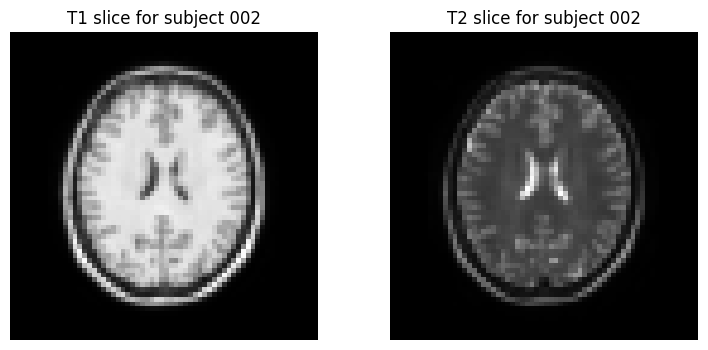

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch


root = "./IXI-dataset/size64/"

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T1.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T1 slice for subject 002")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T2.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T2 slice for subject 002")
plt.axis('off')
plt.show()

Let's import all the necessary packages.

In [ ]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time

Let's create a custom `IXIDataset` class to easily have access to the data.
Here we don't use tsv files to split subjects between the training and the
test set. We only set the dataset to the `train` or `test` mode to access
training or test data.

In [ ]:
class IXIDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Args:
        root: (str) Path of the folder with all the images.
        mode : {'train' or 'test'} Part of the dataset that is loaded.

    """
    def __init__(self, root, mode="train"):

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[:int(0.8 * len(patient_id))]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        elif mode == "test":
            for i in patient_id[int(0.8 * len(patient_id)):]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        self.imgs = imgs

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]

        t1 = torch.load(t1_path)[None, :, :]
        t2 = torch.load(t2_path)[None, :, :]

        return {"T1": t1, "T2": t2}

    def __len__(self):
        return len(self.imgs)

Using this class and the `DataLoader` class from `torch.utils.data`, you can
easily have access to your dataset. Here is a quick example on how to use it:

```python
# Create a DataLoader instance for the training set
# You will get a batch of samples from the training set
dataloader = DataLoader(
    IXIDataset(root, mode="train"),
    batch_size=1,
    shuffle=False,
)

for batch in dataloader:
    # batch is a dictionary with two keys:
    # - batch["T1"] is a tensor with shape (batch_size, 64, 64) with the T1 images for the samples in this batch
    # - batch["T2"] is a tensor with shape (batch_size, 64, 64) with the T2 images for the samples in this batch
```

## 1. Generator

## 1.1 Architecture

The generator will have a **U-Net architecture** with the following
characteristics:

* the descending blocks are convolutional layers followed by instance
  normalization with a LeakyReLU activation function;

* the ascending blocks are transposed convolutional layers followed by
  instance normalization with a ReLU activation function.

The parameters for each layer are given in the picture below.

<a href="https://ibb.co/QXBDNy3">
    <img src="https://i.ibb.co/g614TkL/Capture-d-cran-2020-03-02-16-04-06.png" width="800" border="0">
</a>


<div class="alert alert-block alert-info">
<b>Exercise</b>: Create a <code>GeneratorUNet</code> class to define the
generator with the architecture given above.
</div>

In [ ]:
# We provide classes for each block of the U-Net.

class UNetDown(nn.Module):
    """Descending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.LeakyReLU(0.2)
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    """Ascending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        self.final = FinalLayer(128, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)

        return self.final(u4, d1)

Let's have a look at the architecture of our generator:

In [ ]:
# Summary of the generator
summary(GeneratorUNet().cuda(), (1, 64, 64) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
    InstanceNorm2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
          UNetDown-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-6          [-1, 128, 16, 16]               0
         LeakyReLU-7          [-1, 128, 16, 16]               0
          UNetDown-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-10            [-1, 256, 8, 8]               0
        LeakyReLU-11            [-1, 256, 8, 8]               0
         UNetDown-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
   InstanceNorm2d-14            [-1, 51

## 1.2 Train the generator

In order to train the generator, we will repeat the following process:

1. Generate T2-w images from T1-w images.
2. Compute the error between the true T2-w images and the generated T2-w images.
3. Update the parameters of the generators.

The training phase looks like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator

        # Perform one optimization step
```

<div class="alert alert-block alert-info">
<b>Exercise</b>: We provide below a template to train our generator
 on the dataset. Fill in the missing parts.
</div>

In [ ]:
def train_generator(train_loader, test_loader, num_epoch=500,
                    lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a generator on its own.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping the training dataset
        test_loader: (DataLoader) a DataLoader wrapping the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/generator"):
        os.makedirs("./images/generator")

    # Loss function
    criterion = torch.nn.L1Loss()  # To complete. A loss for a voxel-wise comparison of images like torch.nn.L1Loss

    # Initialize the generator
    generator = GeneratorUNet() # To complete.

    if cuda:
        generator = generator.cuda()
        criterion.cuda()

    # Optimizer
    optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_A = imgs["T1"].type(Tensor)
        real_B = imgs["T2"].type(Tensor)
        fake_B = generator(real_A)
        img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
        save_image(img_sample, f"./images/generator/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)

            # Remove stored gradients
            optimizer.zero_grad()

            # Generate fake T2 images from the true T1 images
            fake_t2 =  generator(real_t1)  # To complete

            # Compute the corresponding loss
            loss = criterion(real_t2, fake_t2)    # To complete

            # Compute the gradient and perform one optimization step
            loss.backward()
            optimizer.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f] ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator

In [ ]:
# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create dataloaders
batch_size = 40
train_loader = DataLoader(IXIDataset(root, mode="train"),
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(IXIDataset(root, mode="test"),
                         batch_size=5,
                         shuffle=False)

# Number of epochs
num_epoch = 20

# Train the generator
generator = train_generator(train_loader, test_loader, num_epoch=num_epoch,
                            lr=lr, beta1=beta1, beta2=beta2)

Using cuda device: True
[Epoch 20/20] [Batch 11/12] [Loss: 0.040761] ETA: 0:00:00.038030

## 1.3 Evaluate the generator

Let's visualize a few generated T2-weighted images:

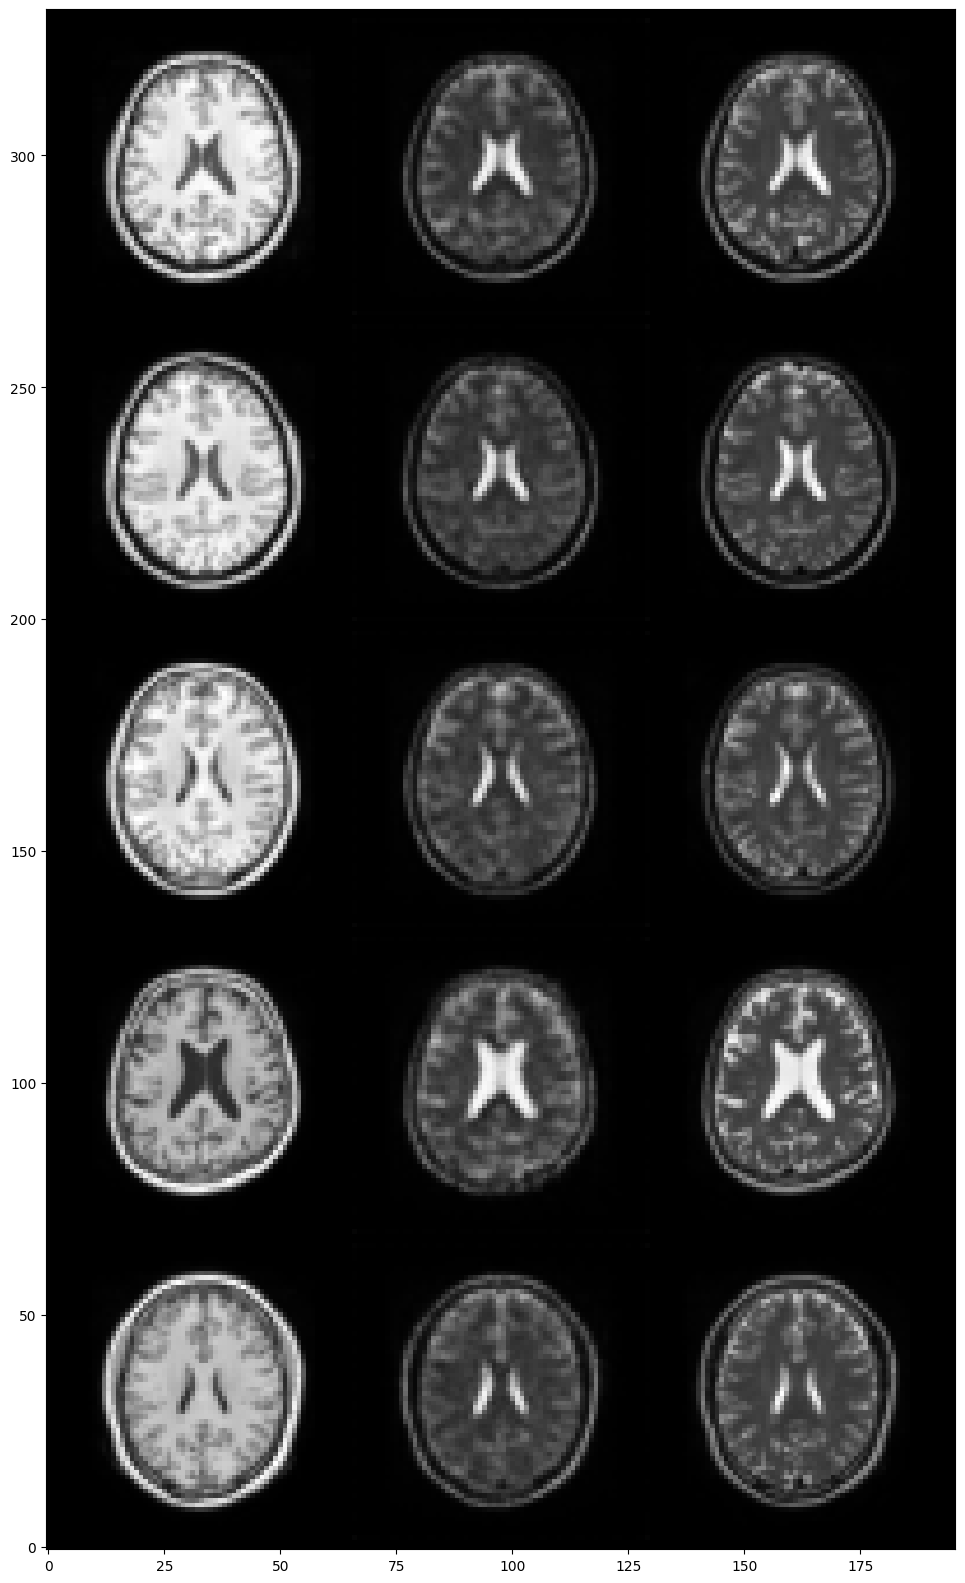

In [ ]:
im = img.imread(f'./images/generator/epoch-{num_epoch - 1}.png')
plt.figure(figsize=(20, 20))
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.show()

After doing visual quality control, it is a good idea to quantify the quality
of the generated images using specific metrics. Some popular metrics include
the Mean Absolute Error (MAE), the Peak Signal-to-Noise Ratio (PSNR) and
the Structural Similarity index (SSIM):

* MAE = $\displaystyle \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m \vert T_{ij} - G_{ij} \vert $

* PSNR = $\displaystyle -10 \log_{10} \left( \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m (T_{ij} - G_{ij})^2 \right) $

* SSIM = $\displaystyle  \frac{(2 \mu_T \mu_G + C_1)(2 \sigma_{TG} + C_2)}{(\mu_T^2 +
\mu_G^2 + C_1)(\sigma_T^2 + \sigma_G^2 + C_2)} $ where:

    * $\mu$ and $\sigma$ are the mean value and standard deviation of an image respectively, and
    * $C_1$ and $C_2$ are two positive constants (one can take $C_1=0.01$ and $C_2=0.03$).

The [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
is simply the mean of each absolute value of the difference between
the true pixel ($T_{ij}$) and the generated pixel ($G_{ij}$).
The lower, the better. Minimum value is 0.

The [peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
is a function of the mean squared error and allows for comparing
images encoded with different scales. We simplified its formula in our case.
The higher, the better. Maximum value is $+\infty$.

The [structural similarity index](https://en.wikipedia.org/wiki/Structural_similarity)
is a weighted combination of the luminance, the contrast and the structure.
The higher, the better. Maximum value is 1.

For those interested, you can find [here](https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
a reference to better understand the differences between these metrics.

We provide an implementation for each metric with the functions below.

In [ ]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

We will now evaluate the generator with these three metrics on both the
training set and the test set by computing the mean value for each metric.

In [ ]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(test_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_test.append([mae, psnr, ssim])

    df = pd.DataFrame([
        pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
        pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
    ], index=['Training set', 'Test set']).T
    return df

In [ ]:
evaluate_generator(generator)

,Training set,Test set
MAE,0.041073,0.048874
PSNR,21.611523,20.099878
SSIM,0.977740,0.966429


The performance is already really good! The task may be pretty easy.
Let's see if we can still improve the performance with a more complex neural
network.

#HW part

## Conditional Generative Adversarial Network (cGAN)

A generative adversarial network (GAN) is a network generating new samples.
A typical GAN consists of two networks:

* a **generator** that generates new samples, and
* a **discriminator** that discriminate generated samples from true samples.

One can think of the generator as a *counterfeiter* and the discriminator
as a *authenticator*.
The discriminator aims at improving the generator by having an opposition.
The discriminator must not be too good, otherwise the generator won't improve.
The generator and the discriminator are trained simultaneously and help
each other improve.

A conditional generative adversarial network (cGAN) is a particular case
of a GAN that is conditioned by the true sample.
A conditional GAN can thus only be used when **paired samples** are available.

### Architecture of the cGAN

Like a GAN, a cGAN has two networks:

* a **generator** that generates new samples, and

* a **discriminator** that discriminate generated samples from true samples.

We will keep the same architecture for the generator.

For the discriminator we will use a **two-dimensional convolutional neural
network** with 5 layers:

* the first 4 layers are 2D-convolutional layers with  a LeakyReLU activation
function;

* the last layer is a 2D-convolutional layer.

The parameters for each layer are given in the figure below. Don't forget
that the input of the discriminator will be the generated image and the true
image since we are using a conditional GAN. Therefore, the number of input
channels for the first layer will be two (one for each image).

<a href="https://ibb.co/9b2jF0V">
  <img src="https://i.ibb.co/hBHvPNZ/Capture-d-cran-2020-03-02-16-04-14.png" width="800"  border="0">
</a>

In [ ]:
# We provide a function to generate a block for the given architecture.
def discriminator_block(in_filters, out_filters):
    """Return downsampling layers of each discriminator block"""
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            *discriminator_block(in_channels*2, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 1, stride=4, padding=0),
        )


    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.layers(img_input)

###Task 1.
Get summary of the discriminator

### Training conditional GAN

Now that we have created our generator and our discriminator, we have to
train them on the dataset.

**Notations**

* $X_{T1}$: true T1 image;
* $X_{T2}$: true T2 image;
* $\tilde{X}_{T2}$: generated T2 image from $X_{T1}$;
* $\hat{y}_{X}$: probability returned by the discriminator that the ${X}_{T2}$ is real;
* $\hat{y}_{\tilde{X}}$: probability returned by the discriminator that the $\tilde{X}_{T2}$ is real.

**Training the generator**

The loss for the generator is the sum of:

* the binary cross-entropy loss between the predicted probabilities of the
generated images and positive labels,
* the pixel-wise mean absolute error between the generated image and the true
image.

For one sample, it is then:

$$
\ell_G = - \log(\hat{y}_{\tilde{X}}) + \lambda * \text{MAE}(X_{T2}, \tilde{X}_{T2})
$$

**Training the discriminator**

The loss for the generator is the mean of:

* the binary cross-entropy loss between the predicted probabilities of the
generated images and negative labels,
* the binary cross-entropy loss between the predicted probabilities
of the true images and positive labels.

For one sample, it is then:

$$
\ell_D = - 0.5 * \log(\hat{y}_{X}) - 0.5 * \log(1 - \hat{y}_{\tilde{X}})
$$

**Training phase**

The generator and the discriminator are trained simultaneously, which makes
the training phase look like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator and perform one optimization step

        # Compute the loss for the discriminator and perform one optimization step
```

In [ ]:
def train_cgan(train_loader, test_loader, num_epoch=500,
               lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a conditional GAN.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/cgan"):
        os.makedirs("./images/cgan")

    # Loss functions
    criterion_GAN = torch.nn.BCEWithLogitsLoss()  # A loss adapted to binary classification like torch.nn.BCEWithLogitsLoss
    criterion_pixelwise = torch.nn.L1Loss()  # A loss for a voxel-wise comparison of images like torch.nn.L1Loss

    lambda_GAN = 1.  # Weights criterion_GAN in the generator loss
    lambda_pixel = 1.  # Weights criterion_pixelwise in the generator loss

    # Initialize generator and discriminator
    generator = GeneratorUNet()
    discriminator = Discriminator()

    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        criterion_GAN.cuda()
        criterion_pixelwise.cuda()

    # Optimizers
    optimizer_generator = torch.optim.Adam(
        generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_discriminator = torch.optim.Adam(
        discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_t1 = imgs["T1"].type(Tensor)
        real_t2 = imgs["T2"].type(Tensor)
        fake_t2 = generator(real_t1)
        img_sample = torch.cat((real_t1.data, fake_t2.data, real_t2.data), -2)
        save_image(img_sample, f"./images/cgan/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)

            # Create labels
            valid = Tensor(np.ones((real_t2.size(0), 1, 1, 1)))
            fake = Tensor(np.zeros((real_t2.size(0), 1, 1, 1)))
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_generator.zero_grad()

            # GAN loss
            fake_t2 = generator(real_t1)
            pred_fake = discriminator(fake_t2, real_t1)
            loss_GAN = criterion_GAN(pred_fake, valid)

            # L1 loss
            loss_pixel = criterion_pixelwise(fake_t2, real_t2)

            # Total loss
            loss_generator = lambda_GAN * loss_GAN + lambda_pixel * loss_pixel

            # Compute the gradient and perform one optimization step
            loss_generator.backward()
            optimizer_generator.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_discriminator.zero_grad()
            # Real loss
            pred_real = discriminator(real_t2, real_t1)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake loss
            fake_t2 = generator(real_t1)
            pred_fake = discriminator(fake_t2.detach(), real_t1)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_discriminator = 0.5 * (loss_real + loss_fake)

            # Compute the gradient and perform one optimization step
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] "
                "[G loss: %f, pixel: %f, adv: %f] ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss_discriminator.item(),
                    loss_generator.item(),
                    loss_pixel.item(),
                    loss_GAN.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator


In [ ]:
generator_cgan = train_cgan(train_loader, test_loader, num_epoch=num_epoch,
                            lr=lr, beta1=beta1, beta2=beta2)

Using cuda device: True
[Epoch 20/20] [Batch 11/12] [D loss: 0.693451] [G loss: 0.708998, pixel: 0.042188, adv: 0.666811] ETA: 0:00:00.115465

### Evaluating the generator of our cGAN

Let's visualize a few generated T2-weighted images:

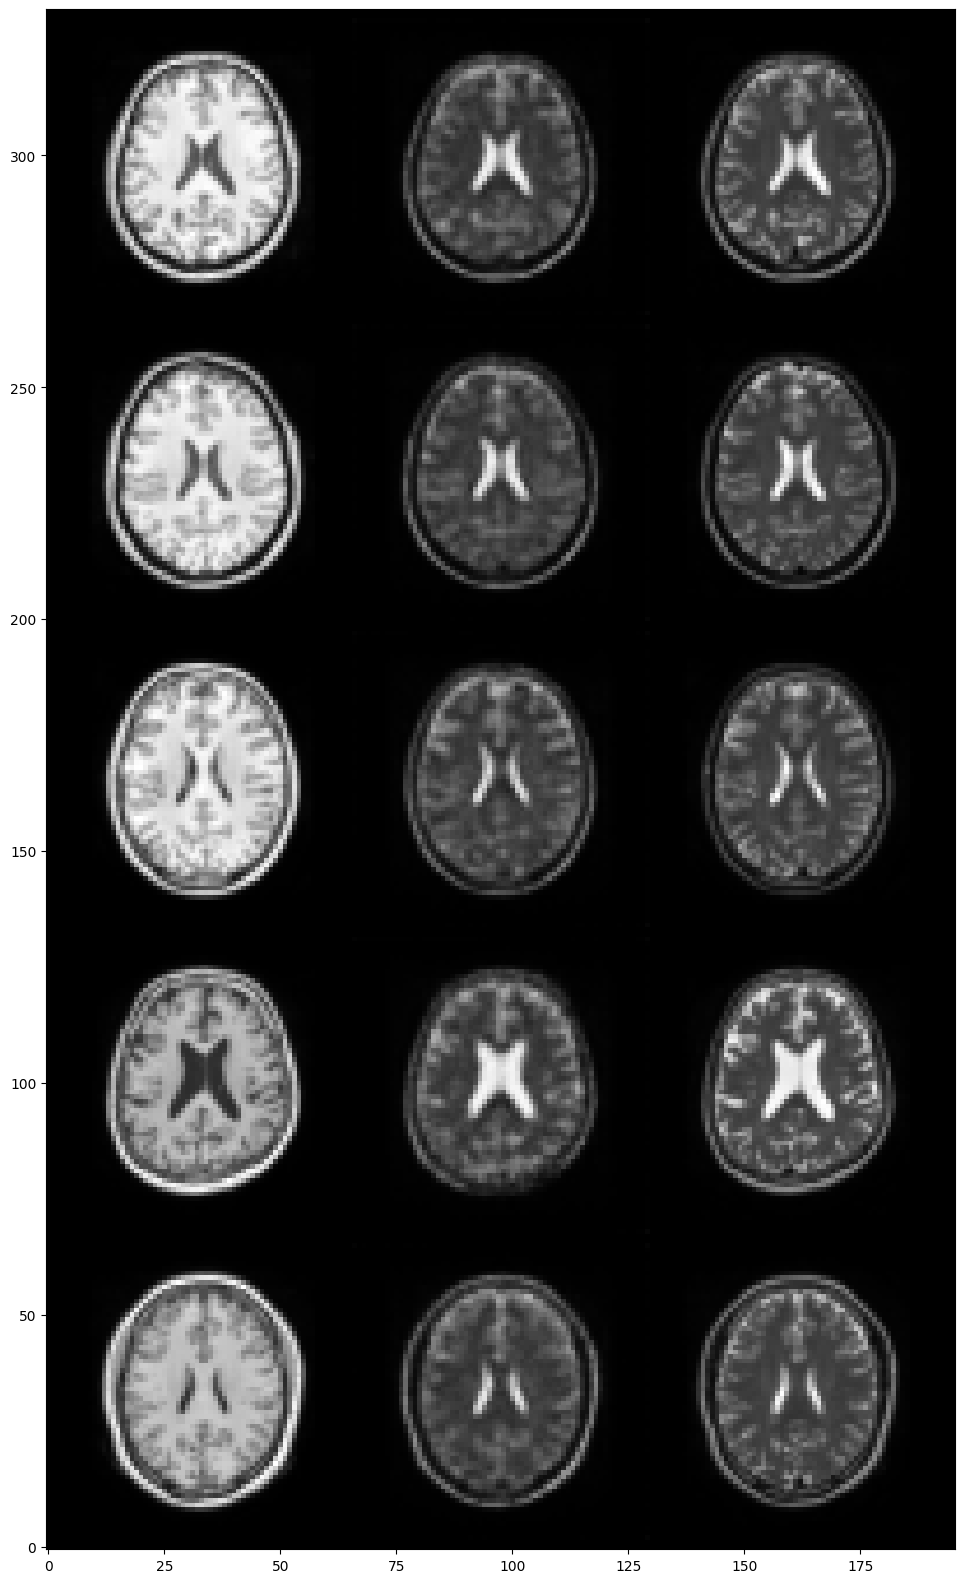

In [ ]:
plt.figure(figsize=(20, 20))
im = img.imread(f'./images/cgan/epoch-{num_epoch - 1}.png')
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
evaluate_generator(generator_cgan)

,Training set,Test set
MAE,0.038227,0.045931
PSNR,22.074553,20.546832
SSIM,0.979550,0.969372


###Task:

Give the comparison of two models.

###Quis

You need to get 3 out of 5 points for quis (1 point per question)


1. GAN training can be considered as a two player minimax game?

####Answer
Yes, GAN training can be considered as a two-player minimax game between the generator and the discriminator. The generator's aim is to generate synthetic data (such as images or text) that can fool the discriminator into classifying it as real, while the discriminator's aim is to discern between real and generated data accurately.

The training process can be modeled as a two-player minmax game, where the generator and discriminator are playing against each other. The generator aims to minimize the discriminator's ability to distinguish between real and generated data, while the discriminator tries to maximize its ability to correctly classify the data.

The ultimate goal of the GAN training is to achieve a point where the generator generates highly realistic and believable data that the discriminator cannot distinguish from real data. This equilibrium is reached when the generator produces data samples that are indistinguishable from the real data distribution, and the discriminator's accuracy in distinguishing them is close to 50%.

2. What are the goals of the generator G in the generative-adversarial model?

a. Discriminator classification error minimization

b. Maximizing the discriminator classification error

c. Minimization of the functional log(1 - D( G(z) ))

d. Minimization of the functional log(1 - G( D(z) ))

####Answer
b. Maximizing the discriminator classification

and

c. Minimization of the functional log(1 - D(G(z))

3. Choose the wrong properties of the KL-divergence of the probability distributions P and Q

a. DKL(P||Q) < 0

b. DKL(P||Q) =DKL(Q||P)

c. DKL(P||Q) = 0 when P=Q

d. 0<DKL(P||Q) < 1

####Answer
a. DKL(P||Q) < 0

and

b. DKL(P||Q) =DKL(Q||P)

and

d. 0<DKL(P||Q) < 1

4. Which GAN learning algorithm is correct?

a. k steps for generator model, then 1 step for discriminator model

b. 1 step for generator model, then 1 step for discriminator model

c. k steps for discriminator model, then 1 step for generator model

####Answer

c. k steps for discriminator model, then 1 step for generator model

5. What is “mode crash”?

This is a problem when ____ (discriminator/generator) learns to fool ____ (discriminator/generator) and starts creating images of ____ (all/just a few) classes from the data set.

####Answer

This is a problem when generator earns to fool the discriminator and starts creating images of just a few classes from the data set.
